# StatsForecast Pipeline - Enhanced with Best Model Selection & Plotting

This notebook includes two new functions:
1. **`select_best_model_per_series()`** - Selects the best model per unique_id based on horizon=8 cross-validation, with consistency metrics and exports low/point/high forecasts to CSV
2. **`plot_forecast_with_intervals()`** - Plots historical data + point forecast + confidence intervals for any unique_id

In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings 
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import (Naive,WindowAverage, ARIMA, AutoARIMA,SeasonalNaive,HoltWinters, CrostonClassic as Croston, HistoricAverage,DynamicOptimizedTheta as DOT,SeasonalNaive)
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple, Union
from itertools import product


warnings.filterwarnings("ignore")  # To ignore warnings from pandas/numpy

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Color palette for up to 4 models
MODEL_COLORS = {
    0: '#E94F37',  # Red
    1: '#2E86AB',  # Blue
    2: '#28A745',  # Green
    3: '#9B59B6',  # Purple
}
HISTORICAL_COLOR = "#898992" 

In [16]:
user="lholguin"

In [17]:
@dataclass
class ForecastConfig:
    
    # Forecast parameters
    h: int = 8                          
    season_length: int = 4              
    
    # Cross-validation parameters
    n_windows: int = 2                  
    step_size: Optional[int] = None     
    
    # Train-test split parameters
    train_size: Optional[int] = None    # Use all available data except test
    test_size: Optional[int] = None     # Auto-set to h in __post_init__
    
    # Plotting parameters
    n_samples: int = 4                  # Plot 4 random samples
    models_to_plot: Optional[List[str]] = None  # 
    
    # Other settings
    confidence_level: int = 95          # 95% confidence intervals
    n_jobs: int = -1                    
    
    def __post_init__(self):
        
        if self.step_size is None:
            self.step_size = self.h
        if self.test_size is None:
            self.test_size = self.h
        if self.models_to_plot is None:
            self.models_to_plot = ['Naive', 'ARIMA_manual', 'SARIMA']

### Data Loading Functions

In [18]:
def load_data_exog(filepath, states=None):

    df = pd.read_csv(filepath)
    df['ds'] = pd.to_datetime(df['Period'], errors='coerce')
    
    df = df[(df['ds'] >= '2017-01-01') & (df['ds'] <= '2024-10-01')].copy()
    
    if states is not None:
        if isinstance(states, str):
            states = [states]
        print(f"Filtering data for states: {states}")
        df = df[df['State'].isin(states)].copy()
        print(f"Filtered to {len(df)} rows across {df['State'].unique()} state(s)")
        if len(df) == 0:
            raise ValueError("No data available after filtering by states.")
    
    df['unique_id'] = df['State'] + '_' + df['ATC2 Class']
    df = df.sort_values(['unique_id','ds']).reset_index(drop=True)

    df_units = df[['unique_id', 'ds', 'Units Reimbursed']].copy()
    df_units.columns = ['unique_id', 'ds', 'y']
    df_units = df_units.dropna(subset=['y'])  

    df_prescriptions = df[['unique_id', 'ds', 'Number of Prescriptions']].copy()
    df_prescriptions.columns = ['unique_id', 'ds', 'y']
    df_prescriptions = df_prescriptions.dropna(subset=['y'])

    return df_units, df_prescriptions, df

def pop_scenarios_exog(filepath,states=None):

    df = pd.read_csv(filepath)
    df['ds'] = pd.to_datetime(df['Period'], errors='coerce')
    
    if states is not None:
        if isinstance(states, str):
            states = [states]
        df = df[df['State'].isin(states)].copy()
    
    df['unique_id'] = df['State'] + '_' + df['ATC2 Class']
    df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    
    df_historical = df[df['ds'] <= '2024-10-01'].copy()
    df_future = df[df['ds'] > '2024-10-01'].copy()

    pop_historical = df_historical[['unique_id', 'ds', 'population']].copy()
    pop_historical.columns = ['unique_id', 'ds', 'population']

    scenarios={}
    pop_future_point = df_future[['unique_id', 'ds', 'population']].copy()
    pop_future_point.columns = ['unique_id', 'ds', 'population']
    scenarios['point'] = pd.concat([pop_historical, pop_future_point], ignore_index=True)
    
    pop_future_low = df_future[['unique_id', 'ds', 'Forecast_low_95']].copy()
    pop_future_low.columns = ['unique_id', 'ds', 'population']
    scenarios['low_95'] = pd.concat([pop_historical, pop_future_low], ignore_index=True)
    
    pop_future_high = df_future[['unique_id', 'ds', 'Forecast_high_95']].copy()
    pop_future_high.columns = ['unique_id', 'ds', 'population']
    scenarios['high_95'] = pd.concat([pop_historical, pop_future_high], ignore_index=True)
    
    for scenario_name, scenario_df in scenarios.items():
        future_count = len(scenario_df[scenario_df['ds'] > '2024-10-01'])
        print(f"   {scenario_name}: {future_count} future population records")
    
    return scenarios

def get_models_exog(config, use_exog=True):
    
    if use_exog:
        models = [
            Naive(),
            SeasonalNaive(season_length=config.season_length),
            HistoricAverage(),
            WindowAverage(window_size=4),
            AutoARIMA(
                seasonal=True, 
                season_length=config.season_length, 
                alias="SARIMAX"
            ),
            AutoARIMA(
                seasonal=False,
                season_length=config.season_length,
                alias="ARIMAX"
            ),
        ]
    else:
        models = [
            Naive(),
            HistoricAverage(),
            WindowAverage(window_size=4),
            SeasonalNaive(season_length=config.season_length),
            ARIMA(order=(1, 1, 1), alias="ARIMA_manual"),
            AutoARIMA(seasonal=True, season_length=config.season_length, alias="SARIMA"),
        ]
    
    return models

---
## NEW FUNCTION 1: Select Best Model Per Series (Horizon=8)

This function:
1. Runs cross-validation with horizon=8
2. Evaluates model consistency across CV windows
3. Selects the best model per unique_id based on consistency and performance
4. Generates forecasts for all three population scenarios (low, point, high)
5. Exports a single CSV with best model forecasts for each scenario

In [19]:
def select_best_model_per_series(
    filepath: str,
    target_col: str,
    states: Optional[List[str]] = None,
    config: Optional[ForecastConfig] = None,
    horizon: int = 8,
    n_windows: int = 3,
    consistency_threshold: float = 0.5,
    metric: str = 'mae',
    save_path: Optional[str] = None
) -> Dict:
    """
    Select the best model per unique_id based on cross-validation performance at horizon=8.
    
    The function evaluates model consistency across CV windows and selects models that:
    - Perform consistently well across multiple CV windows
    - Have high confidence based on agreement between CV folds
    
    Parameters:
    -----------
    filepath : str
        Path to the data file with population scenarios
    target_col : str
        Target column ('Units Reimbursed' or 'Number of Prescriptions')
    states : Optional[List[str]]
        List of states to filter (None for all states)
    config : Optional[ForecastConfig]
        Configuration object (will be created with horizon=8 if None)
    horizon : int
        Forecast horizon (default=8 quarters)
    n_windows : int
        Number of cross-validation windows (default=3)
    consistency_threshold : float
        Minimum consistency ratio to consider a model "highly confident" (default=0.5)
    metric : str
        Evaluation metric ('mae', 'mse', 'smape', 'rmse')
    save_path : Optional[str]
        Path to save the output CSV
    
    Returns:
    --------
    Dict containing:
        - 'best_model_df': DataFrame with best model selection per unique_id
        - 'combined_forecasts': DataFrame with forecasts for all scenarios
        - 'cv_details': Detailed cross-validation results
    """
    
    print("=" * 80)
    print(f"BEST MODEL SELECTION PER SERIES (Horizon={horizon})")
    print(f"Target: {target_col}")
    print("=" * 80)
    
    # Create config if not provided
    if config is None:
        config = ForecastConfig(
            h=horizon,
            season_length=4,
            n_windows=n_windows,
            step_size=4,
            confidence_level=95,
            n_jobs=-1
        )
    
    # Load data
    print("\n📊 Phase 1: Loading data...")
    df_units, df_prescriptions, df_full = load_data_exog(filepath, states)
    df = df_units if target_col == 'Units Reimbursed' else df_prescriptions
    
    print(f"   Unique series: {df['unique_id'].nunique()}")
    print(f"   Date range: {df['ds'].min()} to {df['ds'].max()}")
    
    # Get population scenarios
    pop_scenarios = pop_scenarios_exog(filepath, states)
    
    # Get models
    models = get_models_exog(config, use_exog=True)
    model_names = [m.__class__.__name__ if not hasattr(m, 'alias') else m.alias for m in models]
    
    # Initialize StatsForecast
    sf = StatsForecast(
        models=models,
        freq='QS',
        n_jobs=config.n_jobs,
        fallback_model=SeasonalNaive(season_length=config.season_length)
    )
    
    # Phase 2: Cross-Validation
    print(f"\n🔄 Phase 2: Running Cross-Validation (n_windows={n_windows}, h={horizon})...")
    
    # Use point population scenario for CV
    pop_df = pop_scenarios['point']
    pop_historical = pop_df[pop_df['ds'] <= df['ds'].max()].copy()
    df_with_pop = df.merge(pop_historical, on=['unique_id', 'ds'], how='left')
    
    cv_df = sf.cross_validation(
        df=df_with_pop[['unique_id', 'ds', 'y', 'population']],
        h=horizon,
        n_windows=n_windows,
        step_size=config.step_size
    )
    
    # Get metric function
    metric_funcs = {'mae': mae, 'mse': mse, 'smape': smape, 'rmse': rmse}
    metric_func = metric_funcs.get(metric, mae)
    
    # Evaluate per cutoff
    exclude_cols = ['unique_id', 'ds', 'y', 'cutoff', 'metric', 'population']
    model_cols = [col for col in cv_df.columns if col not in exclude_cols]
    
    cv_results = []
    for cutoff in cv_df['cutoff'].unique():
        cutoff_data = cv_df[cv_df['cutoff'] == cutoff]
        cutoff_eval = evaluate(cutoff_data, metrics=[metric_func], models=model_cols)
        cutoff_eval['cutoff'] = cutoff
        cutoff_eval['best_model'] = cutoff_eval[model_cols].idxmin(axis=1)
        cutoff_eval['best_value'] = cutoff_eval[model_cols].min(axis=1)
        cv_results.append(cutoff_eval)
        print(f"   Cutoff {cutoff.strftime('%Y-%m-%d')}: {cutoff_eval['best_model'].value_counts().to_dict()}")
    
    eval_cv = pd.concat(cv_results, ignore_index=True)
    
    # Phase 3: Select Best Model per Series
    print(f"\n📈 Phase 3: Selecting best model per series...")
    
    best_model_selection = []
    
    for uid in df['unique_id'].unique():
        uid_cv = eval_cv[(eval_cv['unique_id'] == uid) & (eval_cv['metric'] == metric)]
        
        if len(uid_cv) == 0:
            continue
        
        # Count how often each model wins
        model_wins = uid_cv['best_model'].value_counts()
        best_model = model_wins.index[0]
        win_count = model_wins.iloc[0]
        total_windows = len(uid_cv)
        consistency_ratio = win_count / total_windows
        
        # Calculate average metric value for best model
        avg_metric = uid_cv[best_model].mean()
        std_metric = uid_cv[best_model].std()
        
        # Determine confidence level
        if consistency_ratio >= 0.8:
            confidence = 'High'
        elif consistency_ratio >= consistency_threshold:
            confidence = 'Medium'
        else:
            # If no clear winner, use lowest average metric
            avg_metrics = uid_cv[model_cols].mean()
            best_model = avg_metrics.idxmin()
            avg_metric = avg_metrics.min()
            std_metric = uid_cv[best_model].std()
            confidence = 'Low'
        
        best_model_selection.append({
            'unique_id': uid,
            'best_model': best_model,
            'consistency_ratio': consistency_ratio,
            'confidence': confidence,
            'n_windows': total_windows,
            'win_count': win_count,
            f'avg_{metric}': avg_metric,
            f'std_{metric}': std_metric,
        })
    
    best_model_df = pd.DataFrame(best_model_selection)
    
    print(f"\n   Model Selection Summary:")
    print(f"   {best_model_df['best_model'].value_counts().to_dict()}")
    print(f"   Confidence Distribution: {best_model_df['confidence'].value_counts().to_dict()}")
    
    # Phase 4: Generate Forecasts for All Scenarios
    print(f"\n🔮 Phase 4: Generating forecasts for all population scenarios...")
    
    all_forecasts = []
    
    for scenario_name in ['low_95', 'point', 'high_95']:
        print(f"   Processing scenario: {scenario_name}")
        pop_scenario = pop_scenarios[scenario_name]
        
        # Prepare training data with population
        pop_hist = pop_scenario[pop_scenario['ds'] <= df['ds'].max()].copy()
        df_train = df.merge(pop_hist, on=['unique_id', 'ds'], how='left')
        
        # Fit model
        sf.fit(df=df_train[['unique_id', 'ds', 'y', 'population']])
        
        # Prepare future exogenous
        last_date = df['ds'].max()
        future_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=3),
            periods=horizon,
            freq='QS'
        )
        
        future_exog_list = []
        for uid in df['unique_id'].unique():
            for date in future_dates:
                pop_val = pop_scenario[
                    (pop_scenario['unique_id'] == uid) & 
                    (pop_scenario['ds'] == date)
                ]['population'].values
                if len(pop_val) > 0:
                    future_exog_list.append({
                        'unique_id': uid,
                        'ds': date,
                        'population': pop_val[0]
                    })
        
        future_exog_df = pd.DataFrame(future_exog_list)
        
        # Generate point forecasts (no model prediction intervals needed)
        forecasts_df = sf.predict(h=horizon, X_df=future_exog_df)
        forecasts_df = forecasts_df.reset_index()
        
        # Extract best model forecast for each unique_id
        for uid in df['unique_id'].unique():
            uid_forecast = forecasts_df[forecasts_df['unique_id'] == uid].copy()
            uid_best = best_model_df[best_model_df['unique_id'] == uid]
            
            if len(uid_best) == 0 or len(uid_forecast) == 0:
                continue
            
            best_model = uid_best['best_model'].iloc[0]
            
            for _, row in uid_forecast.iterrows():
                forecast_row = {
                    'unique_id': uid,
                    'ds': row['ds'],
                    'population_scenario': scenario_name,
                    'best_model': best_model,
                    'forecast': row.get(best_model, np.nan),
                    'confidence': uid_best['confidence'].iloc[0],
                    'consistency_ratio': uid_best['consistency_ratio'].iloc[0]
                }
                all_forecasts.append(forecast_row)
    
    combined_forecasts_df = pd.DataFrame(all_forecasts)
    
    # Phase 5: Pivot to get low/point/high in columns
    print(f"\n📋 Phase 5: Creating final output format...")
    
    final_output = []
    
    for uid in df['unique_id'].unique():
        uid_data = combined_forecasts_df[combined_forecasts_df['unique_id'] == uid]
        
        for ds in uid_data['ds'].unique():
            ds_data = uid_data[uid_data['ds'] == ds]
            
            point_data = ds_data[ds_data['population_scenario'] == 'point']
            low_data = ds_data[ds_data['population_scenario'] == 'low_95']
            high_data = ds_data[ds_data['population_scenario'] == 'high_95']
            
            if len(point_data) == 0:
                continue
            
            output_row = {
                'unique_id': uid,
                'ds': ds,
                'best_model': point_data['best_model'].iloc[0],
                'confidence': point_data['confidence'].iloc[0],
                'consistency_ratio': point_data['consistency_ratio'].iloc[0],
                # Point forecast (using 'population' column as exogenous)
                'forecast_point': point_data['forecast'].iloc[0],
                # Low population scenario forecast (using 'Forecast_low_95' column as exogenous)
                'forecast_low_pop': low_data['forecast'].iloc[0] if len(low_data) > 0 else np.nan,
                # High population scenario forecast (using 'Forecast_high_95' column as exogenous)
                'forecast_high_pop': high_data['forecast'].iloc[0] if len(high_data) > 0 else np.nan,
            }
            final_output.append(output_row)
    
    final_df = pd.DataFrame(final_output)
    
    # Save to CSV
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        final_df.to_csv(save_path, index=False)
        print(f"\n✅ Saved: {save_path}")
        
        # Also save the model selection summary
        selection_path = save_path.replace('.csv', '_model_selection.csv')
        best_model_df.to_csv(selection_path, index=False)
        print(f"✅ Model selection saved: {selection_path}")
    
    print(f"\n{'='*80}")
    print(f"✅ BEST MODEL SELECTION COMPLETE!")
    print(f"   Total series: {final_df['unique_id'].nunique()}")
    print(f"   Forecast periods: {final_df['ds'].nunique()}")
    print(f"{'='*80}")
    
    return {
        'best_model_df': best_model_df,
        'combined_forecasts': final_df,
        'cv_details': eval_cv,
        'historical_data': df
    }

---
## NEW FUNCTION 2: Plot Historical Data with Forecast and Intervals

This function creates publication-quality plots showing:
- Historical data as a solid line
- Point forecast as a dashed line
- Population scenario range as a shaded band (low to high)
- Low and high population scenario forecasts as dotted lines

In [20]:
def plot_forecast_with_intervals(
    historical_df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    unique_id: str,
    target_name: str = 'Units Reimbursed',
    show_population_scenarios: bool = True,
    figsize: Tuple[int, int] = (14, 8),
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Plot historical data with point forecast and population scenario forecasts for a specific unique_id.
    
    Parameters:
    -----------
    historical_df : pd.DataFrame
        Historical data with columns ['unique_id', 'ds', 'y']
    forecast_df : pd.DataFrame
        Forecast data from select_best_model_per_series() with columns:
        ['unique_id', 'ds', 'forecast_point', 'forecast_low_pop', 'forecast_high_pop', etc.]
    unique_id : str
        The series identifier to plot
    target_name : str
        Name of the target variable for axis labels
    show_population_scenarios : bool
        Whether to show low/high population scenario forecasts as a band
    figsize : Tuple[int, int]
        Figure size
    save_path : Optional[str]
        Path to save the figure
    
    Returns:
    --------
    matplotlib.figure.Figure
    """
    
    # Filter data for the specific unique_id
    hist_data = historical_df[historical_df['unique_id'] == unique_id].copy()
    fore_data = forecast_df[forecast_df['unique_id'] == unique_id].copy()
    
    if len(hist_data) == 0:
        print(f"⚠️ No historical data found for {unique_id}")
        return None
    if len(fore_data) == 0:
        print(f"⚠️ No forecast data found for {unique_id}")
        return None
    
    # Ensure datetime
    hist_data['ds'] = pd.to_datetime(hist_data['ds'])
    fore_data['ds'] = pd.to_datetime(fore_data['ds'])
    
    # Sort by date
    hist_data = hist_data.sort_values('ds')
    fore_data = fore_data.sort_values('ds')
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine scale
    max_val = max(hist_data['y'].max(), fore_data['forecast_point'].max())
    scale = 1e6 if max_val > 1e6 else 1e3 if max_val > 1e3 else 1
    scale_label = 'Millions' if scale == 1e6 else 'Thousands' if scale == 1e3 else ''
    
    # Plot historical data
    ax.plot(
        hist_data['ds'], 
        hist_data['y'] / scale,
        color=HISTORICAL_COLOR,
        linewidth=2.5,
        marker='o',
        markersize=6,
        label='Historical',
        zorder=10
    )
    
    # Get last historical point for connection
    last_hist = hist_data.iloc[-1]
    
    # Plot point forecast
    ax.plot(
        [last_hist['ds'], fore_data['ds'].iloc[0]],
        [last_hist['y'] / scale, fore_data['forecast_point'].iloc[0] / scale],
        color='#E94F37',
        linewidth=2,
        linestyle='--',
        alpha=0.7
    )
    ax.plot(
        fore_data['ds'],
        fore_data['forecast_point'] / scale,
        color='#E94F37',
        linewidth=2.5,
        marker='s',
        markersize=6,
        linestyle='--',
        label='Point Forecast',
        zorder=9
    )
    
    # Show population scenario band (fill between low and high pop forecasts)
    if show_population_scenarios and 'forecast_low_pop' in fore_data.columns and 'forecast_high_pop' in fore_data.columns:
        ax.fill_between(
            fore_data['ds'],
            fore_data['forecast_low_pop'] / scale,
            fore_data['forecast_high_pop'] / scale,
            color='#9B59B6',
            alpha=0.2,
            label='Population Scenario Range',
            zorder=5
        )
        # Also plot the individual lines
        ax.plot(
            fore_data['ds'],
            fore_data['forecast_low_pop'] / scale,
            color='#2E86AB',
            linewidth=1.5,
            linestyle=':',
            marker='^',
            markersize=4,
            label='Low Pop. Scenario',
            alpha=0.7,
            zorder=8
        )
        ax.plot(
            fore_data['ds'],
            fore_data['forecast_high_pop'] / scale,
            color='#28A745',
            linewidth=1.5,
            linestyle=':',
            marker='v',
            markersize=4,
            label='High Pop. Scenario',
            alpha=0.7,
            zorder=8
        )
    
    # Add vertical line at forecast start
    ax.axvline(
        x=last_hist['ds'],
        color='gray',
        linestyle=':',
        linewidth=2,
        alpha=0.7,
        label='Forecast Start'
    )
    
    # Get model info
    best_model = fore_data['best_model'].iloc[0] if 'best_model' in fore_data.columns else 'Unknown'
    confidence = fore_data['confidence'].iloc[0] if 'confidence' in fore_data.columns else 'N/A'
    consistency = fore_data['consistency_ratio'].iloc[0] if 'consistency_ratio' in fore_data.columns else 0
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(f'{target_name} ({scale_label})' if scale_label else target_name, fontsize=12)
    ax.set_title(
        f'{unique_id}: {target_name}\n'
        f'Best Model: {best_model} | Confidence: {confidence} | Consistency: {consistency:.1%}',
        fontsize=14,
        fontweight='bold'
    )
    
    # Legend
    ax.legend(loc='upper left', fontsize=10, ncol=2)
    
    # Date formatting
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4, 7, 10]))
    ax.tick_params(axis='x', rotation=45)
    
    # Grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")
    
    #plt.show()
    return fig


def plot_multiple_forecasts(
    historical_df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    unique_ids: Optional[List[str]] = None,
    n_random: int = 6,
    target_name: str = 'Units Reimbursed',
    show_population_scenarios: bool = False,
    figsize: Tuple[int, int] = (18, 12),
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Plot forecasts for multiple series in a grid layout.
    
    Parameters:
    -----------
    historical_df : pd.DataFrame
        Historical data
    forecast_df : pd.DataFrame
        Forecast data from select_best_model_per_series()
    unique_ids : Optional[List[str]]
        Specific IDs to plot (if None, random selection)
    n_random : int
        Number of random series to plot if unique_ids is None
    target_name : str
        Name of target variable
    show_population_scenarios : bool
        Whether to show population scenario forecasts
    figsize : Tuple[int, int]
        Figure size
    save_path : Optional[str]
        Path to save figure
    
    Returns:
    --------
    matplotlib.figure.Figure
    """
    
    if unique_ids is None:
        all_ids = forecast_df['unique_id'].unique()
        unique_ids = np.random.choice(all_ids, min(n_random, len(all_ids)), replace=False)
    
    n_plots = len(unique_ids)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    for idx, uid in enumerate(unique_ids):
        ax = axes[idx]
        
        hist_data = historical_df[historical_df['unique_id'] == uid].copy()
        fore_data = forecast_df[forecast_df['unique_id'] == uid].copy()
        
        if len(hist_data) == 0 or len(fore_data) == 0:
            ax.set_visible(False)
            continue
        
        hist_data['ds'] = pd.to_datetime(hist_data['ds'])
        fore_data['ds'] = pd.to_datetime(fore_data['ds'])
        hist_data = hist_data.sort_values('ds')
        fore_data = fore_data.sort_values('ds')
        
        # Scale
        max_val = max(hist_data['y'].max(), fore_data['forecast_point'].max())
        scale = 1e6 if max_val > 1e6 else 1e3 if max_val > 1e3 else 1
        scale_label = 'M' if scale == 1e6 else 'K' if scale == 1e3 else ''
        
        # Plot historical
        ax.plot(hist_data['ds'], hist_data['y']/scale, color=HISTORICAL_COLOR, 
                lw=1.5, marker='o', ms=3, label='Historical')
        
        last_hist = hist_data.iloc[-1]
        
        # Plot forecast
        ax.plot([last_hist['ds'], fore_data['ds'].iloc[0]], 
                [last_hist['y']/scale, fore_data['forecast_point'].iloc[0]/scale],
                color='#E94F37', lw=1.5, ls='--', alpha=0.7)
        ax.plot(fore_data['ds'], fore_data['forecast_point']/scale, 
                color='#E94F37', lw=1.5, marker='s', ms=3, ls='--', label='Forecast')
        
        # Show population scenario band
        if show_population_scenarios and 'forecast_low_pop' in fore_data.columns and 'forecast_high_pop' in fore_data.columns:
            ax.fill_between(fore_data['ds'], 
                          fore_data['forecast_low_pop']/scale,
                          fore_data['forecast_high_pop']/scale,
                          color='#9B59B6', alpha=0.15)
            ax.plot(fore_data['ds'], fore_data['forecast_low_pop']/scale,
                   color='#2E86AB', lw=1, ls=':', alpha=0.6)
            ax.plot(fore_data['ds'], fore_data['forecast_high_pop']/scale,
                   color='#28A745', lw=1, ls=':', alpha=0.6)
        
        ax.axvline(x=last_hist['ds'], color='gray', ls=':', alpha=0.5)
        
        # Labels
        best_model = fore_data['best_model'].iloc[0] if 'best_model' in fore_data.columns else ''
        confidence = fore_data['confidence'].iloc[0] if 'confidence' in fore_data.columns else ''
        ax.set_title(f'{uid}\n{best_model} ({confidence})', fontsize=9, fontweight='bold')
        ax.set_ylabel(scale_label, fontsize=8)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.legend(loc='upper left', fontsize=7)
    
    # Hide unused subplots
    for idx in range(len(unique_ids), len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'{target_name} Forecasts with Population Scenarios', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")
    
    #plt.show()
    return fig

---
## Usage Example

In [21]:
# File paths
filepath_withpop = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\P1_withpop.csv"
save_path = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\TMF\\"

In [22]:
# Run best model selection for Units Reimbursed
results = select_best_model_per_series(
    filepath=filepath_withpop,
    target_col='Units Reimbursed',
    states=['IL'],  # Filter for Indiana
    horizon=8,
    n_windows=3,
    consistency_threshold=0.5,
    metric='mae',
    save_path=os.path.join(save_path, 'best_model_forecasts_units.csv')
)

BEST MODEL SELECTION PER SERIES (Horizon=8)
Target: Units Reimbursed

📊 Phase 1: Loading data...
Filtering data for states: ['IL']
Filtered to 2633 rows across ['IL'] state(s)
   Unique series: 83
   Date range: 2017-01-01 00:00:00 to 2024-10-01 00:00:00
   point: 664 future population records
   low_95: 664 future population records
   high_95: 664 future population records

🔄 Phase 2: Running Cross-Validation (n_windows=3, h=8)...
   Cutoff 2020-10-01: {'SARIMAX': 21, 'WindowAverage': 20, 'HistoricAverage': 17, 'Naive': 11, 'SeasonalNaive': 9, 'ARIMAX': 2}
   Cutoff 2021-10-01: {'Naive': 23, 'HistoricAverage': 20, 'SARIMAX': 18, 'WindowAverage': 10, 'ARIMAX': 5, 'SeasonalNaive': 4}
   Cutoff 2022-10-01: {'HistoricAverage': 29, 'SARIMAX': 26, 'Naive': 11, 'WindowAverage': 7, 'ARIMAX': 4, 'SeasonalNaive': 3}
   Cutoff 2018-01-01: {'WindowAverage': 1}
   Cutoff 2019-01-01: {'Naive': 1}
   Cutoff 2020-01-01: {'WindowAverage': 1}
   Cutoff 2020-04-01: {'Naive': 1}
   Cutoff 2021-04-01: {'

In [23]:
# View the best model selection summary
print("\nBest Model Selection Summary:")
print(results['best_model_df'].head(10))

print("\n\nModel Distribution:")
print(results['best_model_df']['best_model'].value_counts())

print("\n\nConfidence Distribution:")
print(results['best_model_df']['confidence'].value_counts())


Best Model Selection Summary:
  unique_id     best_model  consistency_ratio confidence  n_windows  \
0    IL_A01          Naive           0.666667     Medium          3   
1    IL_A02        SARIMAX           1.000000       High          3   
2    IL_A03  WindowAverage           0.666667     Medium          3   
3    IL_A04         ARIMAX           0.666667     Medium          3   
4    IL_A05        SARIMAX           0.666667     Medium          3   
5    IL_A06  WindowAverage           0.666667     Medium          3   
6    IL_A07        SARIMAX           0.666667     Medium          3   
7    IL_A09          Naive           0.666667     Medium          3   
8    IL_A10        SARIMAX           1.000000       High          3   
9    IL_A11  WindowAverage           0.666667     Medium          3   

   win_count       avg_mae       std_mae  
0          2  2.034930e+06  1.317760e+06  
1          3  1.507864e+06  1.263385e+06  
2          2  2.811451e+05  1.676432e+05  
3          2  1

In [24]:
# Plot a single series with confidence intervals
plot_forecast_with_intervals(
    historical_df=results['historical_data'],
    forecast_df=results['combined_forecasts'],
    unique_id='IN_N06',  # Example: Psychoanaleptics in Indiana
    target_name='Units Reimbursed',
    show_population_scenarios=True,
    save_path=os.path.join(save_path, 'IN_N06_forecast.png')
)

⚠️ No historical data found for IN_N06


In [25]:
# Plot multiple series in a grid
'''
plot_multiple_forecasts(
    historical_df=results['historical_data'],
    forecast_df=results['combined_forecasts'],
    unique_ids=['IN_N06', 'IN_C09', 'IN_A10', 'IN_J01', 'IN_R03', 'IN_N02'],
    target_name='Units Reimbursed',
    show_population_scenarios=True,
    save_path=os.path.join(save_path, 'multi_series_forecast.png')
)
'''

"\nplot_multiple_forecasts(\n    historical_df=results['historical_data'],\n    forecast_df=results['combined_forecasts'],\n    unique_ids=['IN_N06', 'IN_C09', 'IN_A10', 'IN_J01', 'IN_R03', 'IN_N02'],\n    target_name='Units Reimbursed',\n    show_population_scenarios=True,\n    save_path=os.path.join(save_path, 'multi_series_forecast.png')\n)\n"

✅ Saved: C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\TMF\\random_series_forecast.png


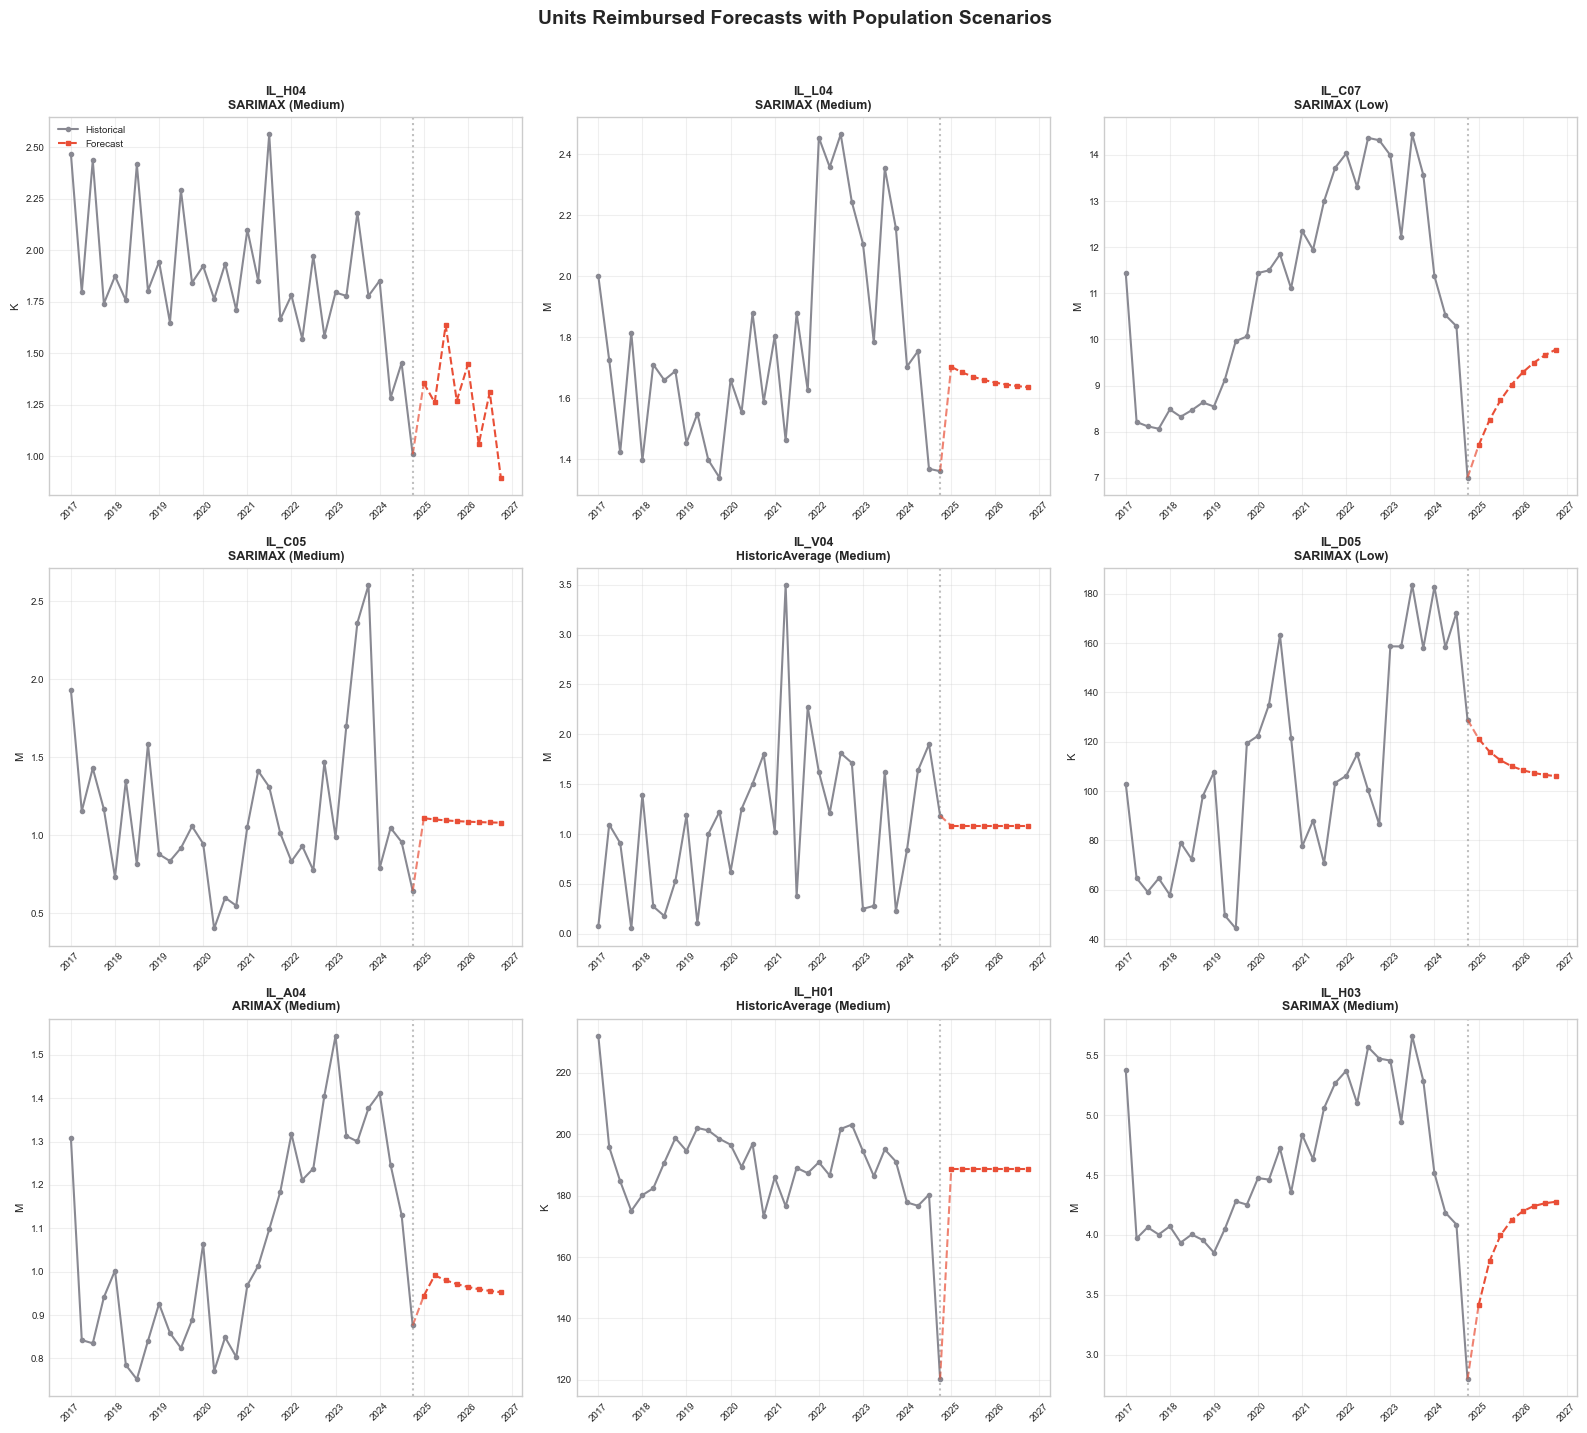

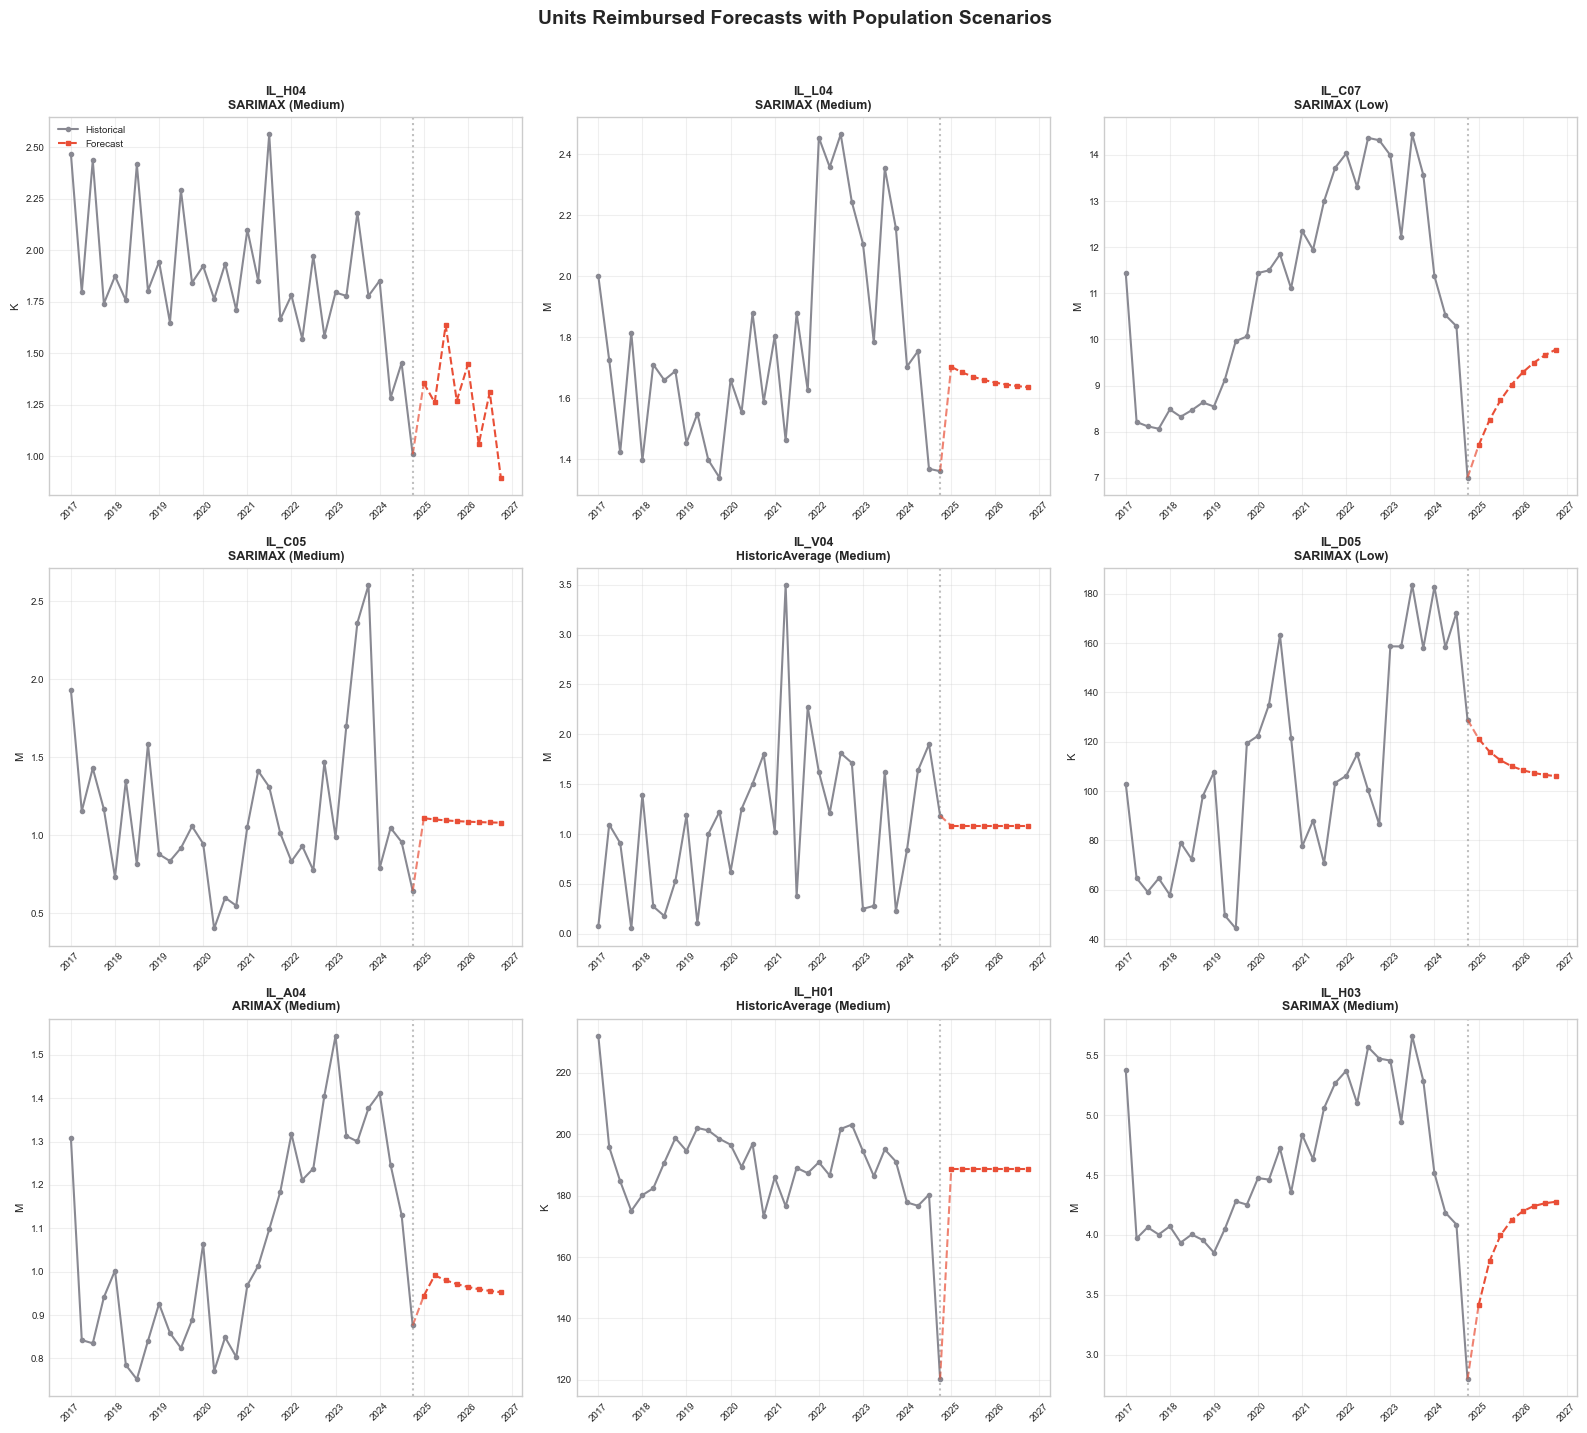

In [26]:
# Plot random series
plot_multiple_forecasts(
    historical_df=results['historical_data'],
    forecast_df=results['combined_forecasts'],
    n_random=9,
    target_name='Units Reimbursed',
    show_population_scenarios=False,
    figsize=(16, 14),
    save_path=os.path.join(save_path, 'random_series_forecast.png')
)

### Run for Number of Prescriptions

In [27]:
# Run for Number of Prescriptions
results_rx = select_best_model_per_series(
    filepath=filepath_withpop,
    target_col='Number of Prescriptions',
    states=['IL'],
    horizon=8,
    n_windows=3,
    consistency_threshold=0.5,
    metric='mae',
    save_path=os.path.join(save_path, 'best_model_forecasts_prescriptions.csv')
)

BEST MODEL SELECTION PER SERIES (Horizon=8)
Target: Number of Prescriptions

📊 Phase 1: Loading data...
Filtering data for states: ['IL']
Filtered to 2633 rows across ['IL'] state(s)
   Unique series: 83
   Date range: 2017-01-01 00:00:00 to 2024-10-01 00:00:00
   point: 664 future population records
   low_95: 664 future population records
   high_95: 664 future population records

🔄 Phase 2: Running Cross-Validation (n_windows=3, h=8)...
   Cutoff 2020-10-01: {'HistoricAverage': 25, 'WindowAverage': 19, 'SARIMAX': 15, 'Naive': 12, 'SeasonalNaive': 7, 'ARIMAX': 2}
   Cutoff 2021-10-01: {'Naive': 23, 'HistoricAverage': 20, 'SARIMAX': 18, 'WindowAverage': 9, 'SeasonalNaive': 8, 'ARIMAX': 2}
   Cutoff 2022-10-01: {'HistoricAverage': 28, 'SARIMAX': 26, 'Naive': 8, 'SeasonalNaive': 7, 'WindowAverage': 6, 'ARIMAX': 5}
   Cutoff 2018-01-01: {'SeasonalNaive': 1}
   Cutoff 2019-01-01: {'Naive': 1}
   Cutoff 2020-01-01: {'WindowAverage': 1}
   Cutoff 2020-04-01: {'Naive': 1}
   Cutoff 2021-04-0

In [28]:
# Plot prescriptions forecast
plot_forecast_with_intervals(
    historical_df=results_rx['historical_data'],
    forecast_df=results_rx['combined_forecasts'],
    unique_id='IN_N06',
    target_name='Number of Prescriptions',
    show_population_scenarios=True,
    save_path=os.path.join(save_path, 'IN_N06_prescriptions_forecast.png')
)

⚠️ No historical data found for IN_N06
